In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/augmented-dataset/train_new/Final AD JPEG/Final AD JPEG_0_796.jpg
/kaggle/input/augmented-dataset/train_new/Final AD JPEG/Final AD JPEG_0_3818.jpg
/kaggle/input/augmented-dataset/train_new/Final AD JPEG/Final AD JPEG_0_9389.jpg
/kaggle/input/augmented-dataset/train_new/Final AD JPEG/Final AD JPEG_0_4721.jpg
/kaggle/input/augmented-dataset/train_new/Final AD JPEG/Final AD JPEG_0_6103.jpg
/kaggle/input/augmented-dataset/train_new/Final AD JPEG/Final AD JPEG_0_8837.jpg
/kaggle/input/augmented-dataset/train_new/Final AD JPEG/Final AD JPEG_0_5153.jpg
/kaggle/input/augmented-dataset/train_new/Final AD JPEG/Final AD JPEG_0_8714.jpg
/kaggle/input/augmented-dataset/train_new/Final AD JPEG/Final AD JPEG_0_4631.jpg
/kaggle/input/augmented-dataset/train_new/Final AD JPEG/Final AD JPEG_0_5325.jpg
/kaggle/input/augmented-dataset/train_new/Final AD JPEG/Final AD JPEG_0_7457.jpg
/kaggle/input/augmented-dataset/train_new/Final AD JPEG/Final AD JPEG_0_6578.jpg
/kaggle/input/augmented-datas

# Introduction

### In this notebook, We have used **CNN** to perform Image Classification on the Alzheimer dataset. Since this dataset is small, if we train a neural network to it, it won't really give us a good result. Therefore, We are going to use the concept of **Transfer Learning** to train the model to get really accurate results.

<img src="1_TUF_YfybJPQ8WA0siWeJTg@2x.jpg" alt="Brain" style="width: 800px;">

# Importing Libraries

In [3]:
import matplotlib.pyplot as plt 
import numpy as np
import os 
from tqdm import tqdm 
import seaborn as sns 
import cv2
import io 

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.applications import EfficientNetB7 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical 
from warnings import filterwarnings 
from PIL import Image 


# Load Training & Testing Images

In [4]:
train_path="/kaggle/input/alzheimers-dataset/train_new_augmented/train_new_augmented"
print("List of Classes:", os.listdir(train_path))
test_path="/kaggle/input/alzheimers-dataset/test/test"
print("List of Classes:", os.listdir(test_path))
labels =['Final AD JPEG', 'Final LMCI JPEG', 'Final MCI JPEG', 'Final CN JPEG', 'Final EMCI JPEG']

List of Classes: ['Final AD JPEG', 'Final LMCI JPEG', 'Final MCI JPEG', 'Final CN JPEG', 'Final EMCI JPEG']
List of Classes: ['Final AD JPEG', 'Final LMCI JPEG', 'Final MCI JPEG', 'Final CN JPEG', 'Final EMCI JPEG']


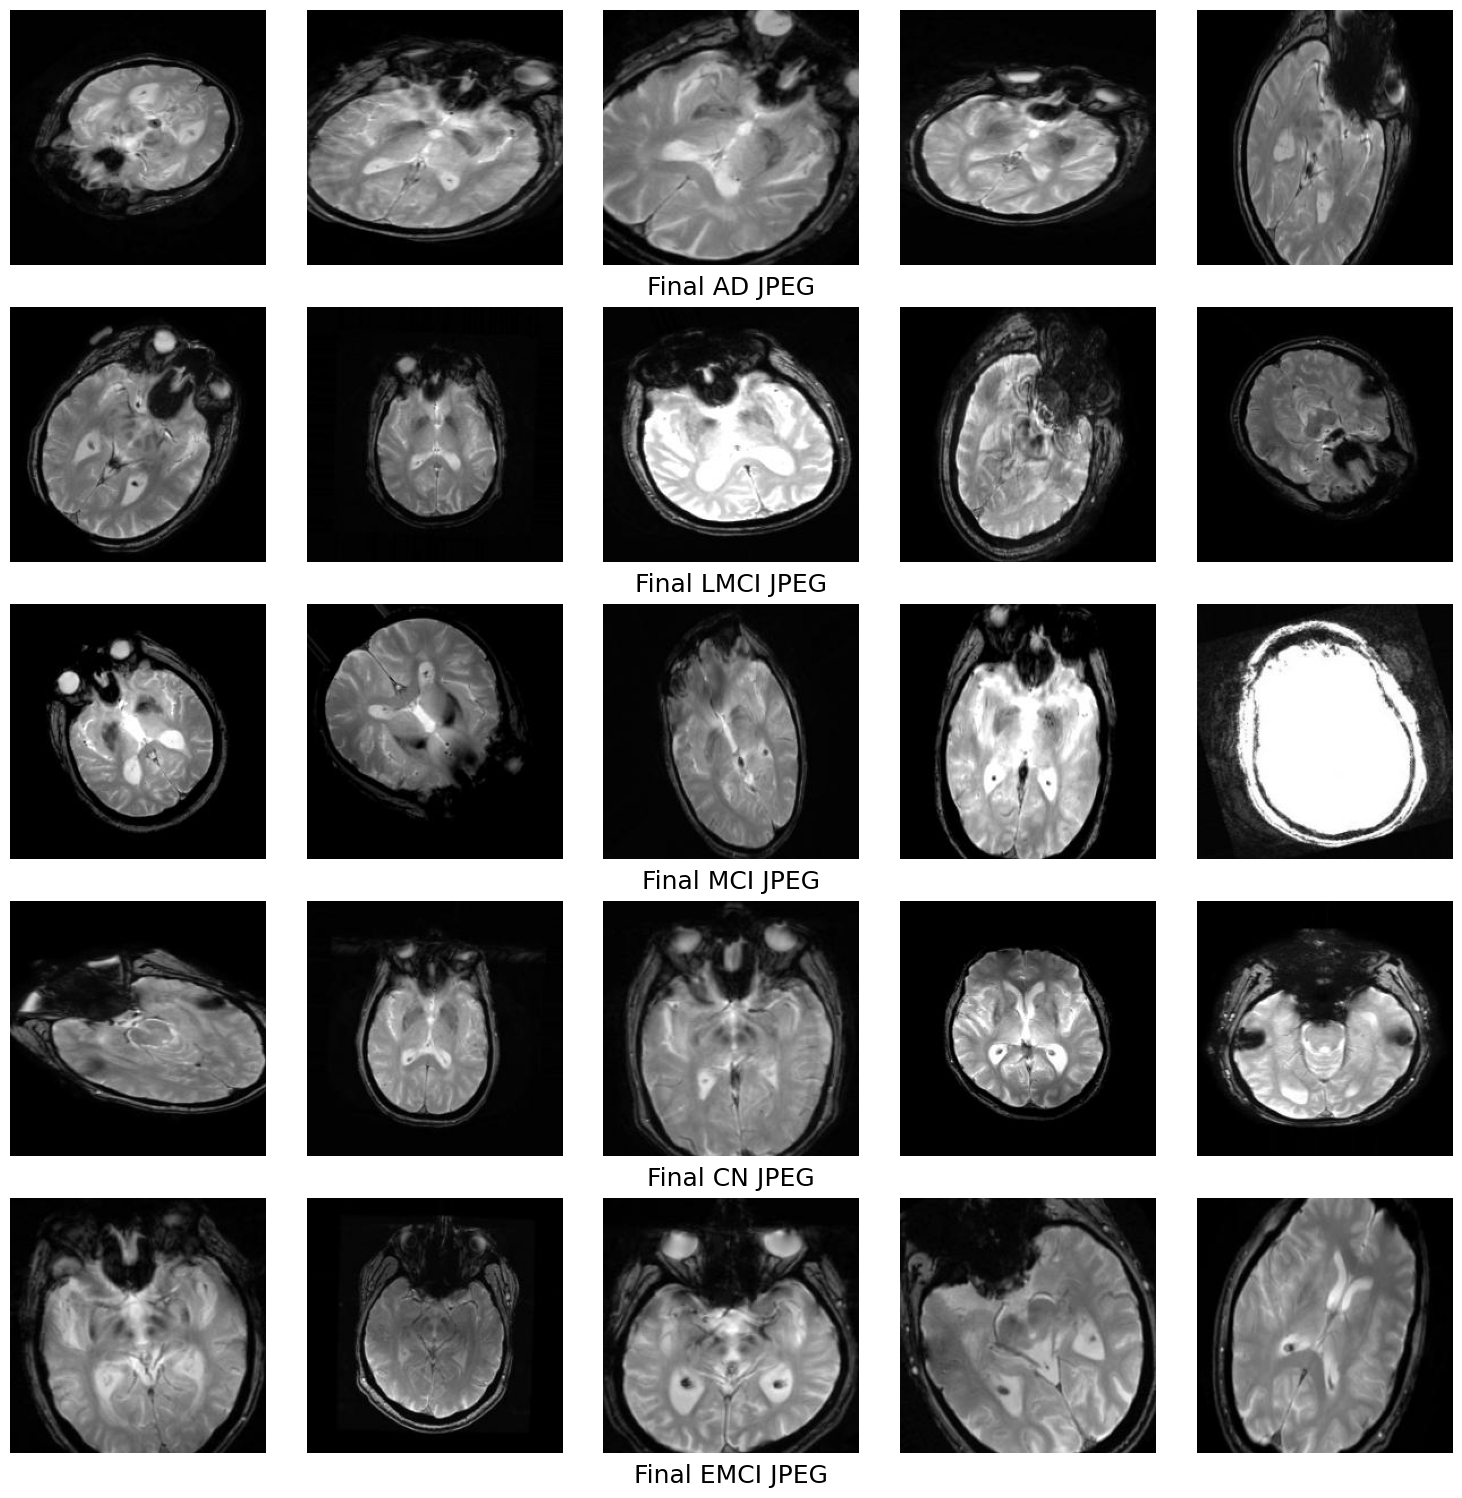

In [8]:
images_per_label = 5
fig, axs = plt.subplots(len(labels), images_per_label, figsize=(15, len(labels) * 3))

for row_idx, label in enumerate(labels):
    label_dir = os.path.join(train_path, label)
    image_files = [f for f in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, f))]
    axs[row_idx, 2].set_title(label, fontsize=18, ha='center', y=-0.15)
    for col_idx in range(images_per_label):
        if col_idx < len(image_files):
            image_path = os.path.join(label_dir, image_files[col_idx])
            image = Image.open(image_path)
            axs[row_idx, col_idx].imshow(image)
            axs[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

Number of images in 'Final AD JPEG': 1176
Number of images in 'Final LMCI JPEG': 697
Number of images in 'Final MCI JPEG': 1219
Number of images in 'Final CN JPEG': 1224
Number of images in 'Final EMCI JPEG': 1239


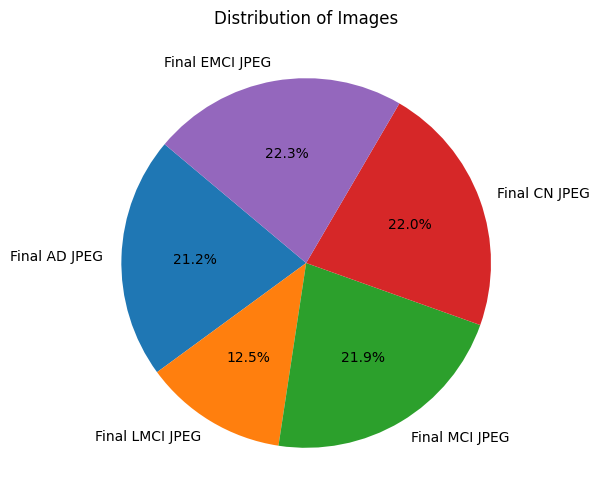

In [19]:
def count_images(folder):
    count = 0
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(".jpeg") or file.endswith(".jpg"):
                count += 1
    return count

subfolder_counts = []
for label in labels:
    subfolder_path = os.path.join(train_path, label)
    images_count = count_images(subfolder_path)
    subfolder_counts.append(images_count)
    print(f"Number of images in '{label}': {images_count}")

plt.figure(figsize=(8, 6))
plt.pie(subfolder_counts, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Images")
plt.show()

In [10]:
X_train=[]
y_train=[]

image_size=162
for i in labels:
    folderDirectory = os.path.join(train_path, i) #tagging labels by i
    for j in tqdm(os.listdir(folderDirectory)): #tqdm counting
        image=cv2.imread(os.path.join(folderDirectory, j)) #image to array
        image=cv2.resize(image, (image_size, image_size))

        X_train.append(image)
        y_train.append(i)
for i in labels:
    folderDirectory=os.path.join(test_path, i)
    for j in tqdm(os.listdir(folderDirectory)):
        image=cv2.imread(os.path.join(folderDirectory, j))
        image=cv2.resize(image, (image_size,image_size))

        X_train.append(image)
        y_train.append(i)
X_train=np.array(X_train)
y_train = np.array(y_train)

print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)

100%|██████████| 36/36 [00:00<00:00, 161.17it/s]


X_train Shape: (5750, 162, 162, 3)
y_train Shape: (5750,)


In [11]:
X_train, y_train = shuffle(X_train, y_train, random_state=101)

# Train Test Split

In [12]:
X_train, X_test, y_train, y_test =train_test_split(X_train, y_train, test_size=0.25, random_state=101)

# One Hot Encoding

In [13]:
y_train_new=[]
y_test_new=[]

for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = to_categorical(y_train)

for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = to_categorical(y_test)

# Creating Convolutional Neural Network Model

In [14]:
efficient = EfficientNetB7(weights ="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [15]:
model=efficient.output
model=tf.keras.layers.GlobalMaxPooling2D()(model)
model=tf.keras.layers.Dropout(0.7)(model)
model=tf.keras.layers.Dense(5, activation="softmax")(model)
model=tf.keras.models.Model(inputs=efficient.input, outputs=model)

#loss for categorical value, adam perform best
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics =["accuracy"])

In [16]:
tensorboard = TensorBoard(log_dir="/kaggle/working/logs")
checkpoint = ModelCheckpoint(
    "/kaggle/working/efficient.keras",
    monitor="val_accuracy",
    verbose=1,
    mode="auto",
    save_best_only=True,
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0.001,
)

In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 162, 162,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 162, 162,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 162, 162,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 162, 162,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 163, 163,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 81, 81,    │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 81, 81,    │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 81, 81,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 81, 81,    │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 81, 81,    │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 81, 81,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 81, 81,    │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 81, 81,    │      2,048 │ block1a_se_excit

 Total params: 64,110,492 (244.56 MB)

 Trainable params: 63,799,765 (243.38 MB)

 Non-trainable params: 310,727 (1.19 MB)

# Training Model

In [11]:
history = model.fit(X_train, y_train,
                   validation_split=0.15,
                   epochs=15, verbose=1,
                   batch_size=32,
                   callbacks =[tensorboard, checkpoint, reduce_lr])

Epoch 1/15


I0000 00:00:1713797220.348990     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713797220.722191     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2501 - loss: 3.1271   

W0000 00:00:1713797544.424024     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713797562.208011     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.33230, saving model to /kaggle/working/efficient.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 734s 3s/step - accuracy: 0.2504 - loss: 3.1183 - val_accuracy: 0.3323 - val_loss: 1.5942 - learning_rate: 0.0010
Epoch 2/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.4282 - loss: 1.3929
Epoch 2: val_accuracy improved from 0.33230 to 0.40649, saving model to /kaggle/working/efficient.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 58s 504ms/step - accuracy: 0.4283 - loss: 1.3925 - val_accuracy: 0.4065 - val_loss: 1.5266 - learning_rate: 0.0010
Epoch 3/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.5853 - loss: 1.0786
Epoch 3: val_accuracy did not improve from 0.40649
115/115 ━━━━━━━━━━━━━━━━━━━━ 53s 464ms/step - accuracy: 0.5852 - loss: 1.0787 - val_accuracy: 0.3988 - val_loss: 1.5513 - learning_rate: 0.0010
Epoch 4/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.7228 - loss: 0.7591
Epoch 4: val_accuracy improved from 0.40649 to 0.

# Save Model

In [13]:
model.save('/kaggle/working/model2.h5')

# Load Model

In [9]:
model = tf.keras.models.load_model('/kaggle/input/models/model3.h5')

# Accuracy, Loss, Learning Rate Vs Epochs Plots

In [14]:
def accuracy_lr_loss_plot (history):
    fig = plt.figure(figsize=(15,10))

    plt.subplot(231)
    plt.plot(history.history["accuracy"], 'bo--', label="accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label="val_accuracy")
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    plt.tight_layout()

    plt.subplot(232)
    plt.plot(history.history['learning_rate'], 'go--', label="Learning Rate")
    plt.title("Learning Rate")
    plt.xlabel("Number of epochs")
    plt.ylabel("Learning Rate")
    plt.grid()
    plt.legend()
    plt.tight_layout()


    plt.subplot(233)
    plt.plot(history.history["loss"], "bo--", label="loss")
    plt.plot(history.history["val_loss"], "ro--", label = "val_loss")
    plt.title("Training Data Loss")
    plt.xlabel("Number of epochs")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    plt.tight_layout()

    plt.show()

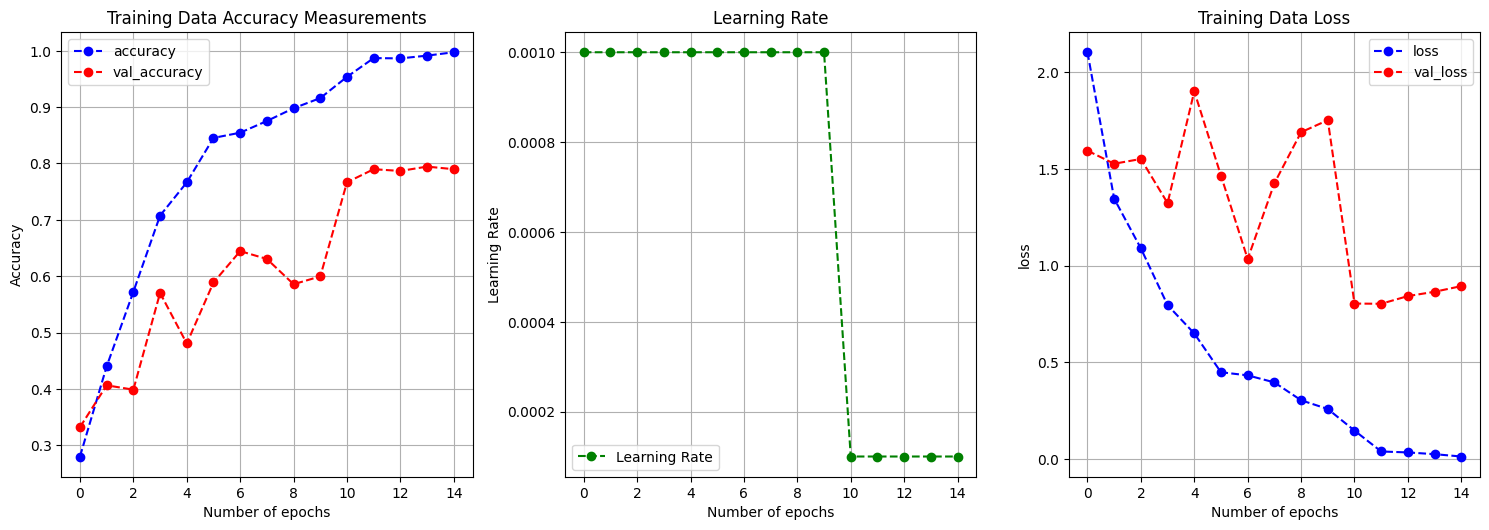

In [15]:
accuracy_lr_loss_plot(history)

# Evaluating Model on Testing Data

In [10]:
X_testloss=model.evaluate(X_test, y_test, verbose=1)

 1/45 ━━━━━━━━━━━━━━━━━━━━ 18:50 26s/step - accuracy: 0.7812 - loss: 0.7544

I0000 00:00:1714205131.222055     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714205131.333257     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 397ms/step - accuracy: 0.7803 - loss: 0.9328


In [11]:
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test_new = np.argmax(y_test, axis=1)

45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 429ms/step


In [12]:
print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       295
           1       0.89      0.81      0.85       184
           2       0.74      0.74      0.74       309
           3       0.71      0.75      0.73       314
           4       0.76      0.77      0.76       336

    accuracy                           0.77      1438
   macro avg       0.79      0.78      0.78      1438
weighted avg       0.78      0.77      0.77      1438



# Confusion Matrix

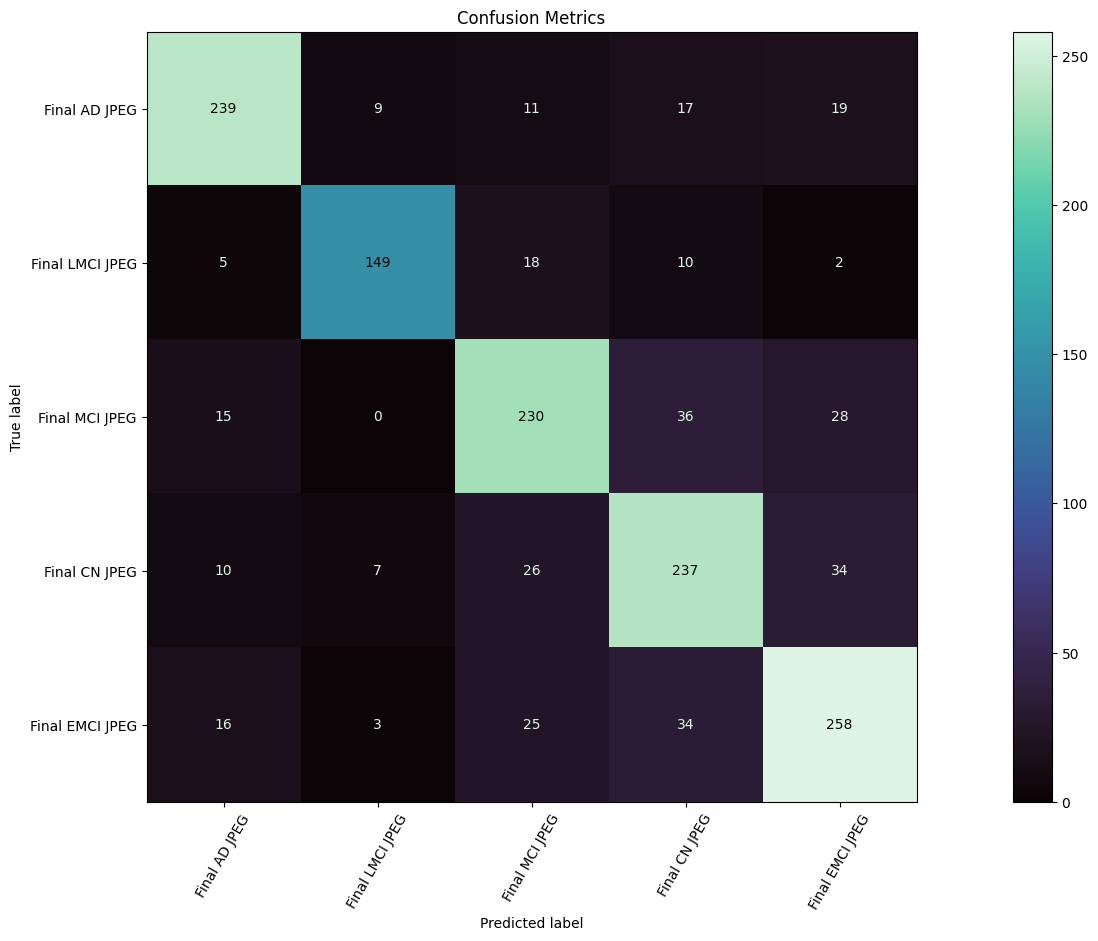

In [13]:
    cm=confusion_matrix(y_test_new, y_pred)
    display_c_m = ConfusionMatrixDisplay(cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(25,10))
    display_c_m.plot(cmap='mako',ax=ax,xticks_rotation=60)
    plt.title("Confusion Metrics")
    plt.show()

In [14]:
TP = np.diag(cm) 
total = cm.sum() 
accuracy = TP.sum() / total
print("Accuracy:", accuracy)

Accuracy: 0.7739916550764951
